[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture3_social_choice_influences.ipynb)

# Lecture 3: Social Choice Theory & Influences

**Topics**: Social Choice, Influences, Effects, Derivatives

**O'Donnell Chapters**: 2.1-2.2
**Notebook by: Gabriel Taboada**

---

## Key Concepts

1. **Social Choice Functions**: Boolean functions as voting systems
2. **Variable Influences**: $\text{Inf}_i[f] = \Pr[f(x) \neq f(x^{\oplus i})]$
3. **Derivative**: $D_i f(x) = f(x^{i \to 1}) - f(x^{i \to 0})$
4. **Banzhaf Power Index**: Voting power from Boolean analysis

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


BooFun version: 1.1.1


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.visualization import BooleanFunctionVisualizer, plot_function_comparison

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Social Choice Functions

A **social choice function** (SCF) is a Boolean function $f: \{-1, +1\}^n \to \{-1, +1\}$ where:
- Each input $x_i \in \{-1, +1\}$ represents voter $i$'s preference
- Output $f(x)$ is the "society's decision"

### Properties of Good Voting Rules
- **Unanimous**: $f(1,1,...,1) = 1$ and $f(-1,-1,...,-1) = -1$
- **Odd**: $f(-x) = -f(x)$ (no bias toward either outcome)
- **Monotone**: If more voters prefer $+1$, outcome shouldn't switch to $-1$
- **Symmetric**: All voters treated equally

In [3]:
# Common social choice functions
n = 5

functions = {
    "Majority": bf.majority(n),      # Most "fair" symmetric rule
    "Dictator": bf.dictator(n, 0),   # One voter decides everything
    "AND": bf.AND(n),                # Unanimous required
    "OR": bf.OR(n),                  # At least one supporter needed
    "Parity": bf.parity(n),          # XOR - balanced but not monotone!
}

print("Social Choice Functions (n=5 voters):")
print(f"{'Function':15} | Balanced | Monotone | Symmetric")
print("-" * 55)
for name, f in functions.items():
    print(f"{name:15} | {str(f.is_balanced()):8} | {str(f.is_monotone()):8} | {str(f.is_symmetric()):8}")

Social Choice Functions (n=5 voters):
Function        | Balanced | Monotone | Symmetric
-------------------------------------------------------
Majority        | True     | True     | True    
Dictator        | True     | True     | False   
AND             | False    | True     | True    
OR              | False    | True     | True    
Parity          | True     | False    | True    


## 2. Variable Influences

The **influence** of variable $i$ measures how often flipping voter $i$'s vote changes the outcome:

$$\text{Inf}_i[f] = \Pr_{x \sim \{-1,+1\}^n}[f(x) \neq f(x^{\oplus i})]$$

### Fourier Formula
$$\text{Inf}_i[f] = \sum_{S: i \in S} \hat{f}(S)^2$$

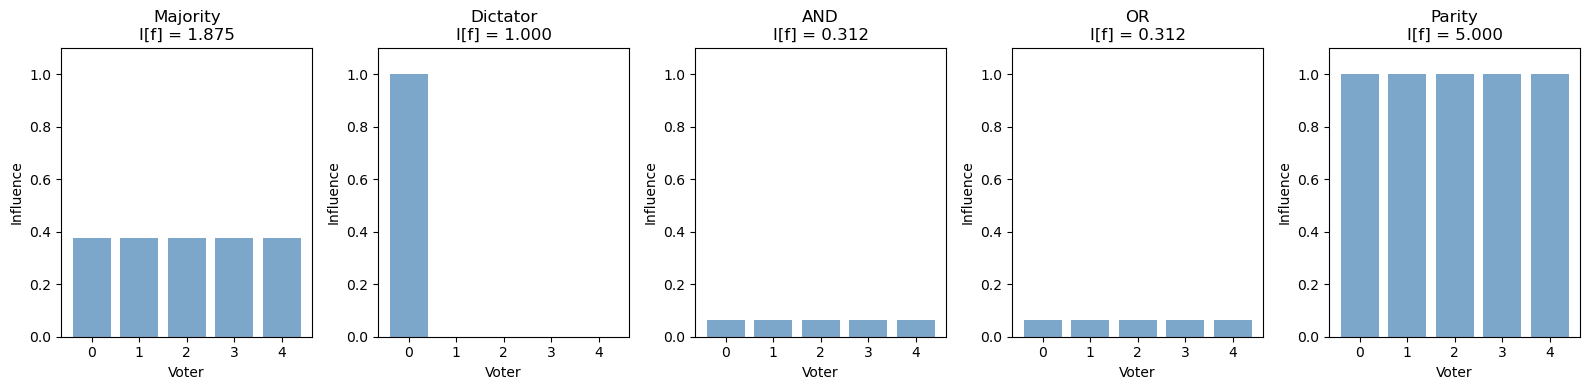


Key Observations:
  Majority: Equal influence (symmetric, monotone)
  Dictator: One voter has all influence
  AND/OR:   Equal but low influence (need many flips to change outcome)
  Parity:   Equal, high influence, but NOT monotone (bad voting rule!)


In [4]:
# Compare influences across different voting rules (reusing functions from above)
fig, axes = plt.subplots(1, len(functions), figsize=(16, 4))

for ax, (name, f) in zip(axes, functions.items()):
    influences = f.influences()
    
    ax.bar(range(n), influences, color='steelblue', alpha=0.7)
    ax.set_title(f"{name}\nI[f] = {f.total_influence():.3f}")
    ax.set_xlabel("Voter")
    ax.set_ylabel("Influence")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(range(n))

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  Majority: Equal influence (symmetric, monotone)")
print("  Dictator: One voter has all influence")
print("  AND/OR:   Equal but low influence (need many flips to change outcome)")
print("  Parity:   Equal, high influence, but NOT monotone (bad voting rule!)")

## 3. Total Influence and Spectral Formula

The **total influence** is:
$$I[f] = \sum_{i=1}^n \text{Inf}_i[f] = \sum_{S} |S| \cdot \hat{f}(S)^2$$

This measures the overall "sensitivity" of the function.

In [5]:
# Verify: I[f] = Σ Inf_i[f] = Σ |S| · f̂(S)²
print("Total Influence: I[f] = Σ Inf_i[f] = Σ|S|·f̂(S)²")
print("=" * 60)
print(f"{'Function':15} | {'Σ Inf_i':<10} | {'Σ|S|·f̂(S)²':<12} | {'f.total_influence()':<10}")
print("-" * 60)

for name, f in functions.items():
    inf_sum = sum(f.influences())
    fourier = f.fourier()
    spectral = sum(bin(s).count('1') * fourier[s]**2 for s in range(2**n))
    direct = f.total_influence()
    
    print(f"{name:15} | {inf_sum:<10.4f} | {spectral:<12.4f} | {direct:<10.4f}")

Total Influence: I[f] = Σ Inf_i[f] = Σ|S|·f̂(S)²
Function        | Σ Inf_i    | Σ|S|·f̂(S)²  | f.total_influence()
------------------------------------------------------------
Majority        | 1.8750     | 1.8750       | 1.8750    
Dictator        | 1.0000     | 1.0000       | 1.0000    
AND             | 0.3125     | 0.3125       | 0.3125    
OR              | 0.3125     | 0.3125       | 0.3125    
Parity          | 5.0000     | 5.0000       | 5.0000    


## 4. Weighted Majority

A **weighted majority** assigns different weights to voters: $f(x) = \text{sign}(\sum_i w_i \cdot x_i)$

This models systems like shareholder voting or the Electoral College.

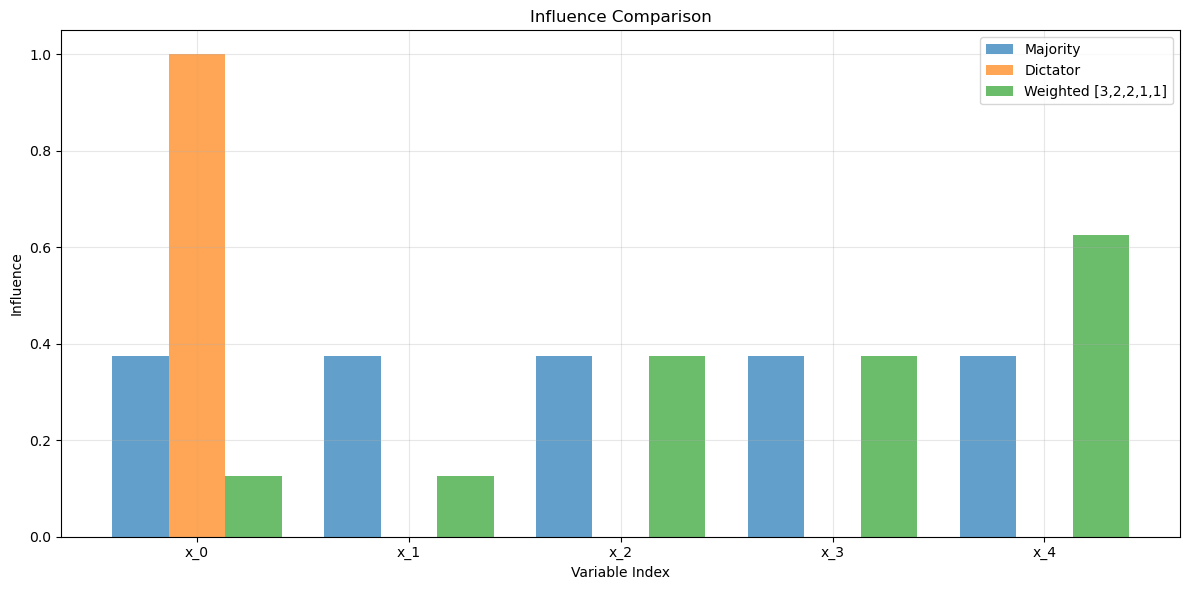


Influence comparison:
  Majority:  Equal power (one person, one vote)
  Dictator:  One voter decides everything
  Weighted:  Influence roughly proportional to weight


In [6]:
# Weighted majority: voter i contributes weight w_i to the sum
# f(x) = sign(Σ w_i · x_i)  -- voters with higher weight have more influence

voting_rules = {
    "Majority": bf.majority(n),
    "Dictator": bf.dictator(n, 0),
    "Weighted [3,2,2,1,1]": bf.weighted_majority([3, 2, 2, 1, 1]),
}

fig = plot_function_comparison(voting_rules, metric="influences")

print("\nInfluence comparison:")
print("  Majority:  Equal power (one person, one vote)")
print("  Dictator:  One voter decides everything")
print("  Weighted:  Influence roughly proportional to weight")

## Summary

### Key Takeaways

1. **Social Choice as Boolean Functions**: Voting rules are monotone, odd Boolean functions

2. **Influence = Voting Power**: $\text{Inf}_i[f]$ measures how often voter $i$ is "pivotal"

3. **Spectral Formula**: $\text{Inf}_i[f] = \sum_{S \ni i} \hat{f}(S)^2$

4. **Total Influence**: $I[f] = \sum_S |S| \cdot \hat{f}(S)^2$

### boofun Usage (Direct API)
```python
# Compute influences - direct methods!
influences = f.influences()
total_inf = f.total_influence()
fourier = f.fourier()

# Create voting functions
maj = bf.majority(n)
dict_f = bf.dictator(n, i)
```